In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.io import wavfile
from scipy.signal import spectrogram
from collections import OrderedDict

/tmp/ipykernel_2747/1772828024.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, track_data = wavfile.read(track_path)


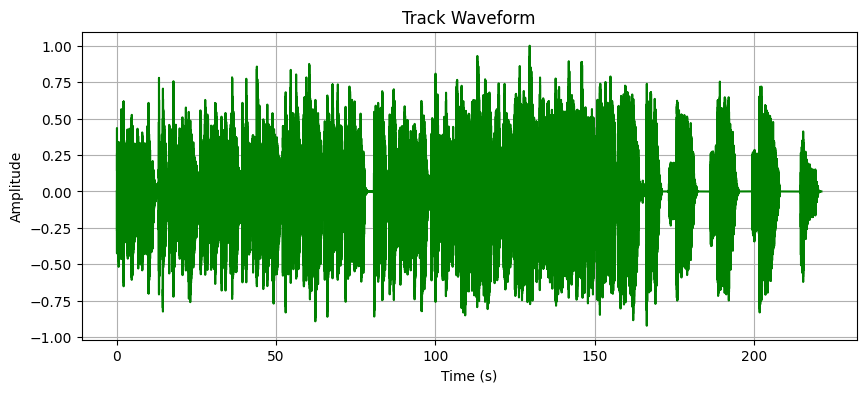

In [3]:
# track_path = "./res/GTZAN/Data/genres_original/pop/pop.00000.wav"
track_path = "res/others/Coldplay_-_The_Scientist_Vocals.wav"
sample_rate, track_data = wavfile.read(track_path)

# Convert stereo audio to mono
if track_data.ndim > 1:
    track_data = track_data.mean(axis=1)

# Normalize the audio data
track_data = track_data.astype(np.float32) / np.max(np.abs(track_data))

# Create the time axis for the waveform plot
duration = len(track_data) / sample_rate
time_data = np.linspace(0.0, duration, len(track_data))


def crop_track(start, end, time_data, track_data, sample_rate):
    duration = len(time_data) / sample_rate
    if start < 0 or start > end or start > duration or end > duration:
        raise RuntimeError("Start/end should be in range")
    start_idx = int(start * sample_rate)
    end_idx = int(end * sample_rate)
    return (
        time_data[start_idx:end_idx],
        track_data[start_idx:end_idx],
    )


# Plot the musical waveform
plt.figure(figsize=(10, 4))
x_data, y_data = crop_track(0, duration, time_data, track_data, sample_rate)
plt.plot(x_data, y_data, color="g")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Track Waveform")
plt.grid(True)
plt.show()

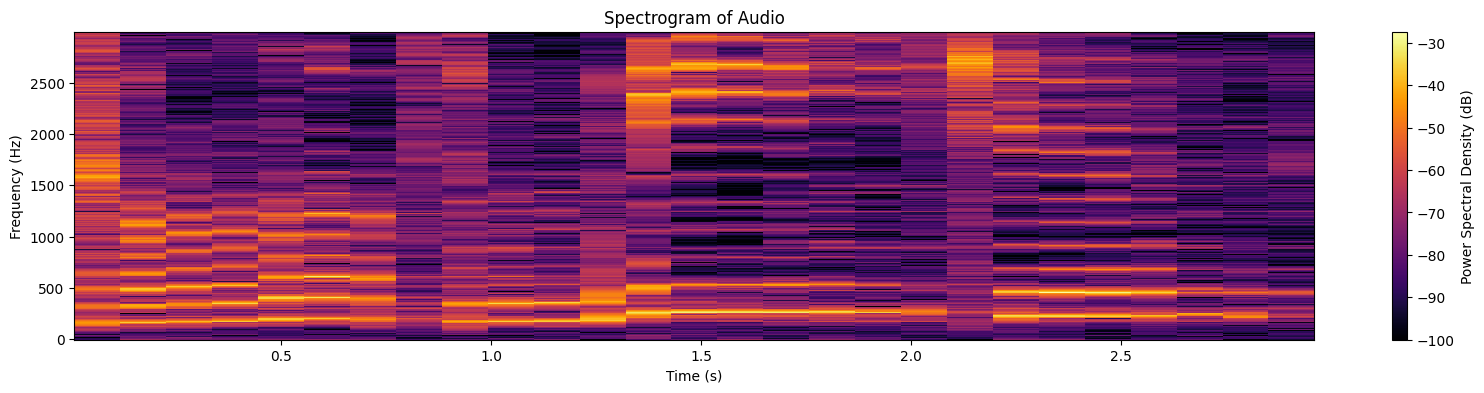

In [4]:

# Compute the spectrogram
nperseg = 6000
frequencies, times, spectrogram_data = spectrogram(track_data, fs=sample_rate, nperseg=nperseg)

# Add a small constant value to the spectrogram data to avoid division by zero
spectrogram_data = np.maximum(spectrogram_data, 1e-10)

def crop_spectogram(start_freq, end_freq, start_time, end_time, frequencies, times, spectrogram_data):
    freq_start_idx = np.searchsorted(frequencies, start_freq)
    freq_end_idx = np.searchsorted(frequencies, end_freq)

    time_start_idx =  np.searchsorted(times, start_time)
    time_end_idx = np.searchsorted(times, end_time)

    f = frequencies[freq_start_idx: freq_end_idx]
    t = times[time_start_idx:time_end_idx]
    s = spectrogram_data[freq_start_idx:freq_end_idx, time_start_idx:time_end_idx]
    return f, t, s 

# Plot the spectrogram
min_freq = 0
max_freq = frequencies.argmax()
start_time = 0
end_time = 3
cropped_frequencies, cropped_times, cropped_spectogram = crop_spectogram(min_freq, max_freq, start_time, end_time, frequencies, times, spectrogram_data)
plt.figure(figsize=(20, 4))
log_spectrogram = 10 * np.log10(cropped_spectogram)
plt.pcolormesh(
    cropped_times, cropped_frequencies, log_spectrogram, shading="auto", cmap="inferno"
)
plt.colorbar(label="Power Spectral Density (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram of Audio")
plt.show()

In [7]:
class Note:
    def __init__(self, key, octave):
        self.key = key
        self.octave = octave

    def __str__(self):
        return self.key + str(self.octave)

    def __repr__(self):
        return self.__str__()
    
    def __hash__(self):
        return hash((self.key, self.octave))
    
    def __eq__(self, other):
        return self.key == other.key and self.octave == other.octave
            
def find_peaks(arr):
    if len(arr) <=2: return arr
    peaks = []
    for i, elem in enumerate(arr[1:-1]):
        prev, next_ = arr[i], arr[i+2]
        if (prev > elem and next_ > elem
           or prev < elem and next_ < elem):
            peaks.append((i, elem))
    return peaks

def find_prominent_frequencies(arr):
    peaks = find_peaks(arr)
    peaks = filter(lambda x: x[1] > -45, peaks)
    freq_iterval = (max_freq - min_freq) / len(arr)
    return list(map(lambda x: (x[0] * freq_iterval, x[1]), peaks))

def frequency_to_midi(x):
    return 69 + 12 * math.log2(x/440)

def midi_to_notation(x):
    midi_note = round(x)
    notes = ("A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#")
    octave = (midi_note - 60 + 12 * 4) // 12
    return Note(notes[(midi_note - 69) % 12], octave)

def freq_to_notation(x):
    return midi_to_notation(frequency_to_midi(x))

def find_prominent_notes(log_spectrogram, time):
    prominent_freq = find_prominent_frequencies(log_spectrogram[:, int((time * sample_rate) / nperseg)])
    prominent_notes = map(lambda x: (freq_to_notation(x[0]), x[1]), prominent_freq)
    return list(prominent_notes)

resolution = 0.2
for time in np.arange(start_time, end_time, resolution):
    notes = find_prominent_notes(log_spectrogram, float(time) - start_time)
    if notes:
        print(f"{time:.2f}: {notes[0:3]}")


0.00: [(D#3, -43.878464), (G6, -40.763535)]
0.20: [(D#3, -36.395348), (D#4, -41.178757), (B4, -37.62978)]
0.40: [(E3, -36.54408), (F4, -34.64517), (C5, -37.760307)]
0.60: [(F#3, -36.70373), (G4, -34.94561), (D5, -42.42294)]
0.80: [(G4, -44.591682), (D5, -42.962555)]
1.00: [(E3, -41.501083), (E4, -41.805172)]
1.20: [(E3, -35.7871), (F4, -34.381565)]
1.40: [(F3, -36.40403), (F#3, -38.968548), (G3, -38.733925)]
1.60: [(B3, -32.145176), (B4, -40.928402), (B4, -42.412067)]
1.80: [(C4, -32.58203), (C5, -42.495594), (D7, -39.160713)]
2.00: [(C4, -34.42009), (C5, -44.530724)]
2.20: [(C4, -35.44315)]
2.40: [(E7, -43.452675), (E7, -44.173485), (E7, -44.638638)]
2.60: [(A3, -33.956467), (A#4, -36.1959)]
2.80: [(A3, -35.666405), (A4, -30.136717)]


In [10]:
import musicalbeeps

player = musicalbeeps.Player(volume = 0.5,
                            mute_output = False)

for time in np.arange(start_time, end_time, resolution):
    notes = find_prominent_notes(log_spectrogram, float(time) - start_time)
    if notes[0][1] > -40:
        print(notes[0][0])
        player.play_note(str(notes[0][0]), resolution)
    else:
        player.play_note("pause", resolution)
    


# from gensound import Triangle

# sig = Triangle # Sine? Square?
# beat = 0.5e3 # 120 bpm
# pause = 0.6 # and breathe for a moment before starting the next phrase

# resolution = 0.2
# signals = {}
# for time in np.arange(0, end_time, resolution):
#     notes = find_prominent_notes(log_spectrogram, float(time))
#     singable_notes = list(set(filter(is_singable_note, notes)))
#     if singable_notes:
#         for i, note in enumerate(singable_notes):
#             signals[i] = signals.setdefault(i, "") + f" {note}"
#     else:
#         for key in signals:
#             signals[key] = signals[key] + f" r={resolution}"
# for s in signals:
#     signals[s] = sig(signals[s], beat)

# import operator
# import functools
# chorale = functools.reduce(operator.add, signals.values())
# chorale.play()


Pausing for 0.2s
D#3


Error: invalid octave: '#'
Error: invalid octave: '#'


E3
Playing E3 (164.81 Hz) for 0.2s
F#3
Pausing for 0.2s
Pausing for 0.2s
E3
Playing E3 (164.81 Hz) for 0.2s
F3
Playing F3 (174.61 Hz) for 0.2s
B3
Playing B3 (246.94 Hz) for 0.2s
C4
Playing C4 (261.63 Hz) for 0.2s
C4
Playing C4 (261.63 Hz) for 0.2s
C4
Playing C4 (261.63 Hz) for 0.2s
Pausing for 0.2s
A3
Playing A3 (220.00 Hz) for 0.2s
A3
Playing A3 (220.00 Hz) for 0.2s
